In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import random
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# from keras import applications
# from keras import optimizers
# from keras.models import Sequential, Model
# from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
# from keras import backend as K
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
%matplotlib inline

Using TensorFlow backend.


### Preparing custom images data for training

In [2]:
train_dir = '/home/mo/box/inception/data/train'
filenames = os.listdir(train_dir)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    "filename": filenames,
    "category": categories
})

In [3]:
df.head()

,category,filename
0,0,cat.6557.jpg
1,0,cat.3446.jpg
2,1,dog.4847.jpg
3,1,dog.8482.jpg
4,1,dog.7915.jpg


### See random image

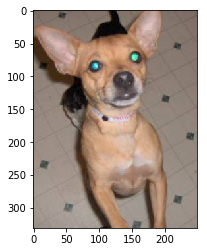

In [4]:
random_img = random.choice(filenames)
img = Image.open(os.path.join(train_dir, random_img))
plt.imshow(img)

### Typical input image size for CNN training is 224x224, 227x227

In [6]:
IMAGE_WIDTH, IMAGE_HEIGHT = 256, 256
FAST_RUN = False
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

W0623 19:07:01.586576 139996380084032 deprecation_wrapper.py:119] From /home/mo/anaconda3/envs/inception35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0623 19:07:01.596623 139996380084032 deprecation_wrapper.py:119] From /home/mo/anaconda3/envs/inception35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0623 19:07:01.644395 139996380084032 deprecation_wrapper.py:119] From /home/mo/anaconda3/envs/inception35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0623 19:07:01.645209 139996380084032 deprecation_wrapper.py:119] From /home/mo/anaconda3/envs/inception35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is d

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
__________

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [9]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [10]:
df.head()

,category,filename
0,cat,cat.6557.jpg
1,cat,cat.3446.jpg
2,dog,dog.4847.jpg
3,dog,dog.8482.jpg
4,dog,dog.7915.jpg


In [11]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [12]:
train_df.shape
# train_df['category'].value_counts().plot.bar()
# validate_df['category'].value_counts().plot.bar()

(20000, 2)

In [13]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

### Traning Generator

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_dir,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [15]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_dir,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 5000 validated image filenames belonging to 2 classes.


### See how our generator work

In [19]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    train_dir,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


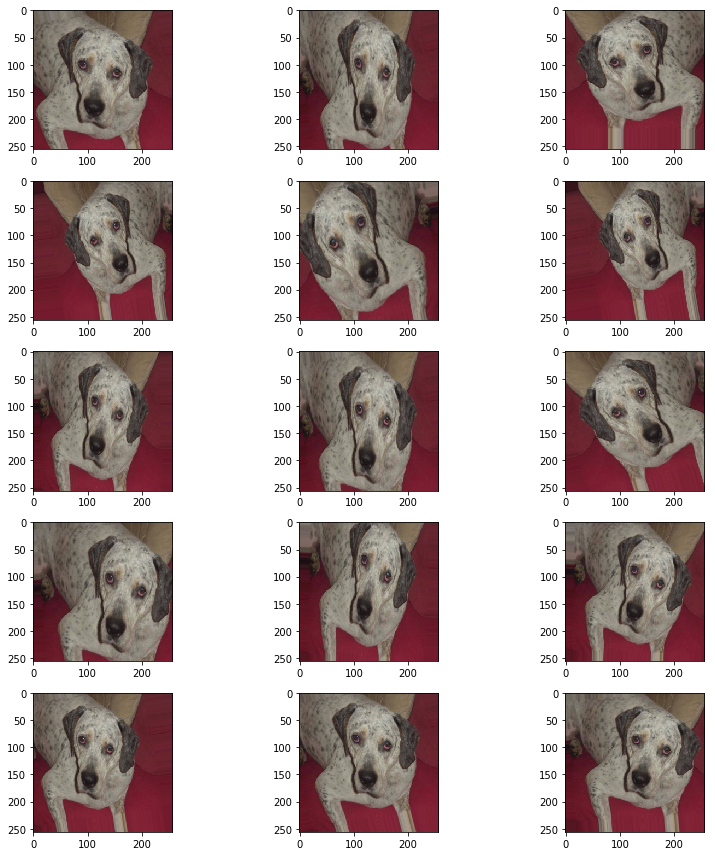

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [22]:
from IPython.display import display
from PIL import Image

epochs=3 if FAST_RUN else 50
print(epochs)
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

W0623 19:08:31.425359 139996380084032 deprecation.py:323] From /home/mo/anaconda3/envs/inception35/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


50
Epoch 1/50
 102/1333 [=>............................] - ETA: 1:02:36 - loss: 1.4812 - acc: 0.5529

KeyboardInterrupt: 